# Caso Base: CVRP Estándar

In [4]:
from geopy.distance import geodesic
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import folium
from folium import plugins
from folium.plugins import MarkerCluster

In [5]:

#----- procesamiento de datos/ encontrando las distancias entre todas las locations -----
# https://geopy.readthedocs.io/en/stable/#module-geopy.distance 

clientes = pd.read_csv('Proyecto_Caso_Base/clients.csv')
depositos = pd.read_csv('Proyecto_Caso_Base/depots.csv')
vehiculos = pd.read_csv('Proyecto_Caso_Base/vehicles.csv')
for i in range(len(depositos)):
    data= {'LocationID': depositos['LocationID'][i],
            'Longitude': depositos['Longitude'][i],
            'Latitude': depositos['Latitude'][i],}
    data_f = pd.DataFrame([data])
    data_f.to_csv('Proyecto_Caso_Base/locations.csv', index=False)

for i in range(len(clientes)):
    data= {'LocationID': clientes['LocationID'][i],
            'Longitude': clientes['Longitude'][i],
            'Latitude': clientes['Latitude'][i],}
    data_f = pd.DataFrame([data])
    # modo a es de append pa ir añadiendo y como ya tiene encabezados header se pone en False
    data_f.to_csv('Proyecto_Caso_Base/locations.csv', mode='a', header=False, index=False)

locations_csv = pd.read_csv('Proyecto_Caso_Base/locations.csv')

distancias = []
for i in range(len(locations_csv)):
    latitud = locations_csv['Latitude'][i]
    longitud = locations_csv['Longitude'][i]
    coord = (latitud, longitud)
    locs_i=[]
    j=0
    #cuando hagamos los otros casos hay que cambiar ese 25
    while j<25:
        latitud2 = locations_csv['Latitude'][j]
        longitud2 = locations_csv['Longitude'][j]
        coord2 = (latitud2, longitud2)

        locs_i.append(geodesic(coord, coord2).kilometers)
    
        j+=1
    # df_locs_i = pd.DataFrame([locs_i])
    # df_locs_i.to_csv('Proyecto_Caso_Base/distancias.csv', mode='a', header=False, index=False)
    distancias.append(locs_i)


# Formulación matemática corregida del problema

## 1. Formulación del Modelo
Dadas algunas correciones del enunciado y de nuestro modelo original, finalmente se creo este modelo matemático final. Los cambios principales subyacen en el manejo del parámetro de $distancia_{ij}$, y en el uso de las demanadas de cada cliente/municipio. A continuación se explicará cómo fue el modelo que implementamos en este primer caso.
### 1.1. Conjuntos

* $L = \{1, ..., n\} $: Conjunto de localidades, donde \$1\$ representa el puerto.
* $D = \{2, ..., n\}$ : Conjunto de destinos/clientes.
* $V = \{1, ..., m\}$ : Conjunto de vehículos disponibles.

### 1.2. Índices

* $i, j \in L$ : Localidades origen y destino.
* $k \in V$ : Vehículo.

### 1.3. Parámetros

* $distancias_{ij}$: Distancia entre localidad $i$ y $j$.
* $D\_demanda\_i$: Demanda del cliente $i \in D$.
* $V\_capacidad\_k$: Capacidad máxima del vehículo $k$.
* $V\_autonomia\_k$: Autonomía máxima del vehículo $k$.
* $n$: Número total de localidades (incluye el puerto).

### 1.4. Variables de decisión

* $x_{ijk} \in {0,1}$: 1 si el vehículo $k$ viaja de $i$ a $j$, 0 en otro caso.
* $u_{ik} \in \mathbb{Z}$: Orden de visita de $i$ por el vehículo $k$ (usado para eliminar subciclos).

---

## 2. Función Objetivo

Minimizar la distancia total recorrida por todos los vehículos:

$$
\min \sum_{k \in V} \sum_{i \in L} \sum_{j \in L, j \ne i} distancias_{ij} \cdot x_{ijk}
$$

---

## 3. Restricciones

### (0) Prohibir viajes del puerto a sí mismo:

$$
x_{11k} = 0 \quad \forall k \in V
$$

### (1) Cada cliente debe ser visitado exactamente una vez:

$$
\sum_{k \in V} \sum_{\substack{i \in L \\ i \ne j}} x_{ijk} = 1 \quad \forall j \in D
$$

### (2) Cada vehículo debe salir una sola vez del puerto:

$$
\sum_{j \in L, j \ne 1} x_{1jk} = 1 \quad \forall k \in V
$$

### (3) Cada vehículo debe regresar una vez al puerto:

$$
\sum_{i \in L, i \ne 1} x_{i1k} = 1 \quad \forall k \in V
$$

### (4) Conservación de flujo en los nodos:

$$
\sum_{\substack{i \in L \\ i \ne h}} x_{ihk} = \sum_{\substack{j \in L \\ j \ne h}} x_{hjk} \quad \forall h \in D, \forall k \in V
$$

### (5) Eliminación de subciclos (MTZ):

$$
u_{ik} - u_{jk} + n \cdot x_{ijk} \leq n - 1 \quad \forall i \ne j \in D, \forall k \in V
$$

### (6) Capacidad de cada vehículo:

$$
\sum_{i \in D} D\_demanda_i \cdot \sum_{\substack{j \in L \\ j \ne i}} x_{ijk} \leq V\_capacidad_k \quad \forall k \in V
$$

### (7) Autonomía de cada vehículo:

$$
\sum_{\substack{i,j \in L \\ i \ne j}} distancias_{ij} \cdot x_{ijk} \leq V\_autonomia_k \quad \forall k \in V
$$

---



In [6]:

#----- modelo para resolver el caso base -----
# Implementar un modelo básico tipo CVRP con un origen nacional (puerto) y destinos (municipios).
# Incluir restricciones de capacidad y autonomía de los vehículos.
# Validar factibilidad de la solución considerando solamente distancia y demanda.

Model = ConcreteModel()

numPuertos = 1
numPuntosDestino = 24
numLocalidades = len(distancias)
numVehiculos = 8

# Conjuntos
P= RangeSet(1, numPuertos) 
D = RangeSet(2, numLocalidades)   
V = RangeSet(1, numVehiculos)
L= RangeSet(1, numLocalidades)
nodos = [_ for _ in range(numLocalidades)]


# Parámetros
D_demanda = {}
for i in range(2, numPuntosDestino+2):
    D_demanda[i] = clientes['Demand'][i-2]

V_capacidad = {}
for i in range(1, numVehiculos+1):
    V_capacidad[i] = vehiculos['Capacity'][i-1]
    
V_autonomia = {}
for i in range(1, numVehiculos+1):
    V_autonomia[i] = vehiculos['Range'][i-1]

tarifa_flete_km = 5000   # Ft
costo_mantenimiento_km = 700  # Cm
costo = tarifa_flete_km + costo_mantenimiento_km

# Variables de decisión
Model.x = Var(L,L,V, domain=Binary) # x[i,j,k] = 1 si el vehiculo k viaja de i a j
Model.u = Var(D, V, bounds=(1, numLocalidades - 1), domain=Integers) # u[i,k] = número de localidades visitadas por el vehículo k al visitar la localidad i 


# Función objetivo: minimizar la distancia total recorrida
Model.obj = Objective(
    expr=sum(costo*distancias[i-1][j-1]*Model.x[i,j,k] 
             for i in L for j in L for k in V if i != j),
    sense=minimize
)

# Restricción 0: el vehículo no puede salir del puerto/deposito para visitar el puerto/deposito
# (esto es para evitar que el vehículo salga y vuelva al puerto/deposito sin visitar ningún cliente)
Model.res0 = ConstraintList()
for k in V:
    Model.res0.add(Model.x[1, 1, k] == 0)


# Restricción 1: cada cliente debe ser visitado exactamente una vez
Model.res1 = ConstraintList()
for j in D:
    Model.res1.add(
        sum(Model.x[i,j,k] for i in L if i != j for k in V) == 1
    )

# Restricción 2: desde el depósito/puerto sale un nodo por vehículo
Model.res2 = ConstraintList()
for k in V:
    Model.res2.add(
        sum(Model.x[1,j,k] for j in L if j != 1) == 1
    )

# Restricción 3: al depósito/puerto llega un nodo por vehículo
Model.res3 = ConstraintList()
for k in V:
    Model.res3.add(
        sum(Model.x[i,1,k] for i in L if i != 1) == 1
    )

# Restricción 4: si un vehículo entra a un nodo, también debe salir de él. Conservación de flujo
Model.res4 = ConstraintList()
for k in V:
    for h in D:
        Model.res4.add(
            sum(Model.x[i,h,k] for i in L if i != h) == sum(Model.x[h,j,k] for j in L if j != h)
        )

# Restricción 5: eliminación de subciclos (MTZ)
Model.res5 = ConstraintList()
for k in V:
    for i in D:
        for j in D:
            
            if i != j:
                Model.res5.add(
                    Model.u[i,k] - Model.u[j,k] + numLocalidades * Model.x[i,j,k] <= numLocalidades - 1
                )

# Restricción 6 : Capacidad de cada vehículo
Model.res6 = ConstraintList()
for k in V:
    Model.res6.add(
        sum(D_demanda[i] * sum(Model.x[j,i,k] for j in L if j != i) for i in D) <= V_capacidad[k]
    )


# Restricción 7: Autonomía de cada vehículo
Model.res7 = ConstraintList()
for k in V:
    Model.res7.add(
        sum(distancias[i-1][j-1] * Model.x[i,j,k] for i in L for j in L if i != j) <= V_autonomia[k]
    )

solver = SolverFactory('glpk')
solver.options['tmlim'] = 300 # tiempo límite de 5 minutos
results = solver.solve(Model, tee=True)


def exportar_resultados_vehiculos(Model, distancias, D_demanda, V_capacidad, V_autonomia, L, D, V, velocidad=50, tarifa_flete=5000, costo_mantenimiento=700):
    columnas = [
        'VehicleId', 'LoadCap', 'FuelCap', 'RouteSequence', 'Municipalities', 'DemandSatisfied',
        'InitialLoad', 'InitialFuel', 'Distance', 'Time', 'TotalCost'
    ]
    resultados = []
    # recrear el modelo para obtener los resultados
    for k in V:
        ruta = [1]
        actual = 1

        while True:
            siguiente = None
            for j in L:
                if j != actual and Model.x[actual, j, k].value and Model.x[actual, j, k].value > 0.5:
                    siguiente = j
                    ruta.append(j)
                    actual = j
                    break
            if siguiente is None or actual == 1:
                break
            

        nombres_ruta = ["PTO"] + [f"MUN{str(nodo).zfill(2)}" for nodo in ruta[1:-1]] + ["PTO"]
        route_sequence = " - ".join(nombres_ruta)
        municipios = [n for n in ruta if n in D_demanda]
        demandas = [D_demanda[n] for n in municipios]
        demanda_str = "-".join(str(int(d)) if d.is_integer() else str(d) for d in demandas)
        distancia_total = sum(distancias[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1)  )
        tiempo_min = round((distancia_total / velocidad) * 60, 1)   # minutos
        total_cost = round(distancia_total * (tarifa_flete + costo_mantenimiento))

        resultados.append([
            f"CAM{str(k).zfill(3)}",             # VehicleId
            V_capacidad[k],                      # LoadCap
            V_autonomia[k],                      # FuelCap
            route_sequence,                      # RouteSequence
            len(municipios),                     # Municipalities
            demanda_str,                         # DemandSatisfied
            sum(demandas),                       # InitialLoad
            V_autonomia[k],                      # InitialFuel
            round(distancia_total, 1),           # Distance
            tiempo_min,                          # Time
            total_cost                           # TotalCost
        ])
    df_resultados = pd.DataFrame(resultados, columns=columnas)
    df_resultados.to_csv("Proyecto_Caso_Base/verificacion_caso1.csv", index=False)
    return df_resultados

df = exportar_resultados_vehiculos(Model, distancias, D_demanda, V_capacidad, V_autonomia, L, D, V)
distancia_total = df['Distance'].sum()
print(f'Distancia total recorrida por todos los vehículos: {round(distancia_total, 2)} km')


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 300 --write C:\Users\maria\AppData\Local\Temp\tmp6ji_5p53.glpk.raw
 --wglp C:\Users\maria\AppData\Local\Temp\tmpaq15sfec.glpk.glp --cpxlp C:\Users\maria\AppData\Local\Temp\tmpab92t6vf.pyomo.lp
Reading problem data from 'C:\Users\maria\AppData\Local\Temp\tmpab92t6vf.pyomo.lp'...
C:\Users\maria\AppData\Local\Temp\tmpab92t6vf.pyomo.lp:60891: warning: lower bound of variable 'x4803' redefined
C:\Users\maria\AppData\Local\Temp\tmpab92t6vf.pyomo.lp:60891: warning: upper bound of variable 'x4803' redefined
4672 rows, 5000 columns, 36872 non-zeros
5000 integer variables, 4808 of which are binary
65699 lines were read
Writing problem data to 'C:\Users\maria\AppData\Local\Temp\tmpaq15sfec.glpk.glp'...
56011 lines were written
GLPK Integer Optimizer 5.0
4672 rows, 5000 columns, 36872 non-zeros
5000 integer variables, 4808 of which are binary
Preprocessing...
4416 constraint coefficient(s) were reduced
4664 rows, 4

# Discusiones de respuestas
## Resultados Solver
### Justificación de solver
GLPK (GNU Linear Programming Kit) es un solver libre y de código abierto diseñado para resolver problemas de programación lineal (LP) y programación entera mixta (MIP). En el contexto del Problema de Ruteo de Vehículos con Capacidad y Autonomía (CVRP), se trata de un problema clásico de optimización combinatoria que involucra variables binarias y restricciones lineales, lo que lo hace compatible con GLPK.Aunque el solver no alcanzó la solución óptima debido al límite de tiempo, logró encontrar una solución factible con un gap aceptable del 17.2%, lo que indica una solución cercana al óptimo. Adicionalmente, GLPK manejó correctamente la estructura del modelo (más de 300,000 nodos de búsqueda), lo que demuestra su estabilidad en instancias medianas del problema.


### Resumen del Proceso de Optimización (GLPK)

| Métrica                          | Valor                             |
|----------------------------------|------------------------------------|
| Escalado inicial (A)             | min = 0.3446, max = 25.00, ratio ≈ 72.55 |
| Escalado con GM                  | min = 0.3063, max = 3.265, ratio ≈ 10.66 |
| Escalado EQ                      | min = 0.09381, max = 1.00, ratio ≈ 10.66 |
| Escalado 2N                      | min = 0.08615, max = 1.50, ratio ≈ 17.41 |
| Fase LP: valor objetivo inicial  | 219.355                            |
| Fase LP: valor óptimo relajación | 150.904                            |
| Tiempo total usado (límite)      | 300 segundos                       |
| Memoria usada                    | 269.6 MB                           |
| GAP final                        | 17.2%                              |
| Soluciones enteras encontradas   | múltiples                          |
| Estado final                     | Límite de tiempo alcanzado (factible) |

## Rutas por Vehículo y Costos

| Vehículo | Capacidad | Autonomía | Ruta                                     | # Clientes | Demanda Total | Distancia (km) | Tiempo (h) | Costo ($) |
|----------|-----------|-----------|------------------------------------------|------------|----------------|----------------|------------|-----------|
| CAM001   | 130       | 170       | PTO - MUN15 - PTO                        | 1          | 15             | 8.0            | 0.16       | 45,636    |
| CAM002   | 140       | 200       | PTO - MUN06 - MUN09 - ... - MUN19 - PTO | 8          | 133            | 54.6           | 1.09       | 310,980   |
| CAM003   | 120       | 180       | PTO - MUN10 - ... - MUN07 - PTO         | 7          | 118            | 43.8           | 0.88       | 249,732   |
| CAM004   | 100       | 90        | PTO - MUN24 - PTO                        | 1          | 15             | 8.6            | 0.17       | 49,173    |
| CAM005   | 70        | 100       | PTO - MUN13 - PTO                        | 1          | 12             | 11.9           | 0.24       | 67,788    |
| CAM006   | 55        | 170       | PTO - MUN04 - PTO                        | 1          | 12             | 12.7           | 0.25       | 72,622    |
| CAM007   | 110       | 150       | PTO - MUN03 - ... - MUN22 - PTO         | 4          | 57             | 37.1           | 0.74       | 211,329   |
| CAM008   | 114       | 140       | PTO - MUN21 - PTO                        | 1          | 15             | 7.1            | 0.14       | 40,264    |

### Distancia Total Recorrida: **183.78 km**


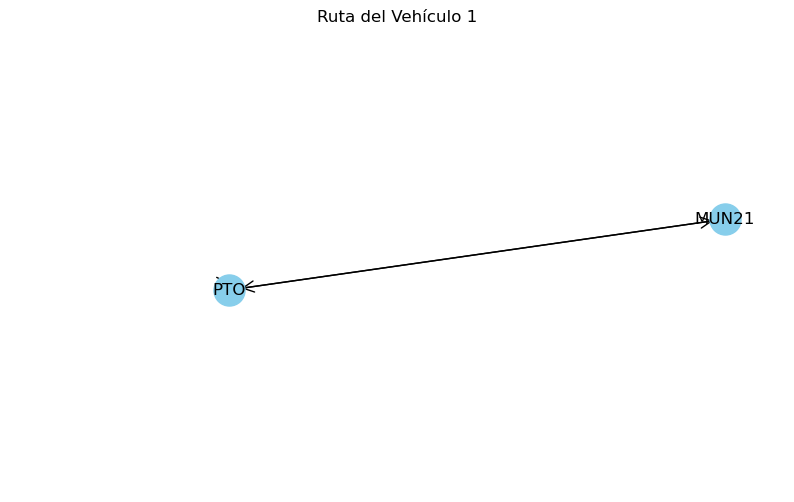

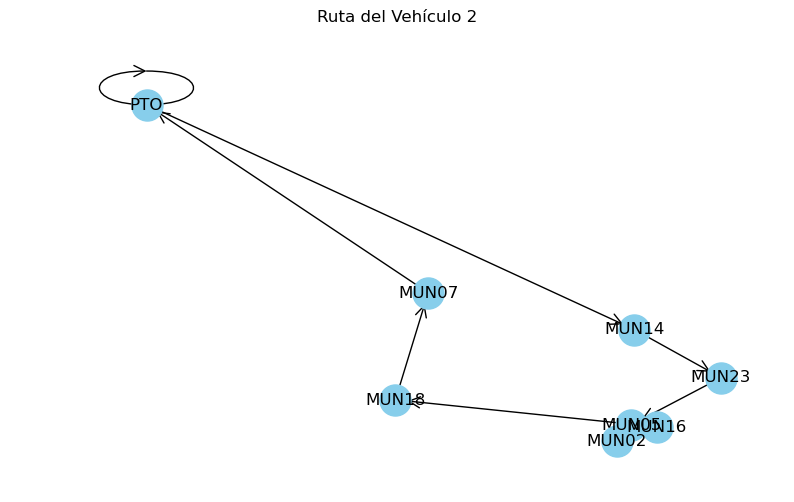

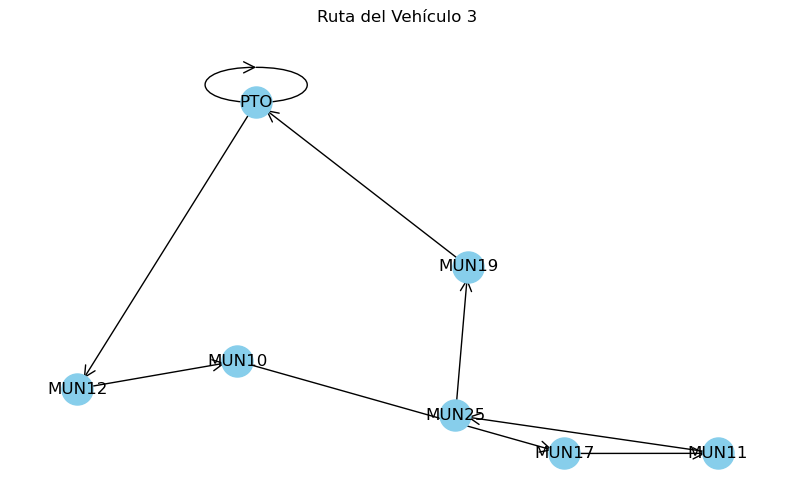

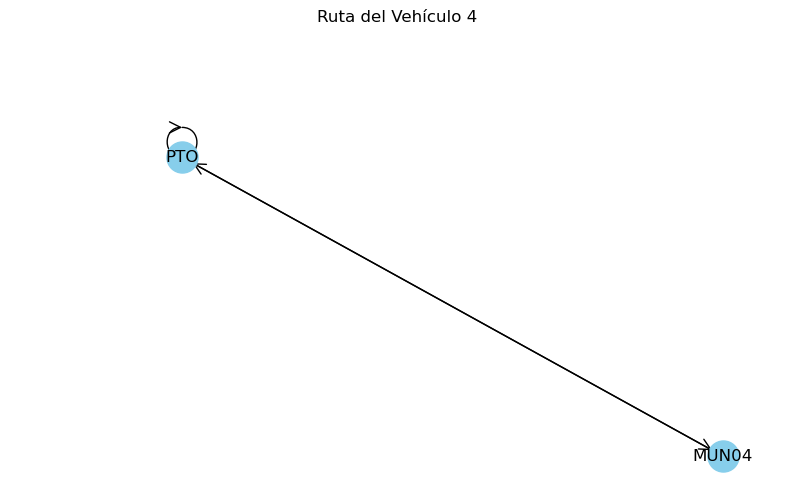

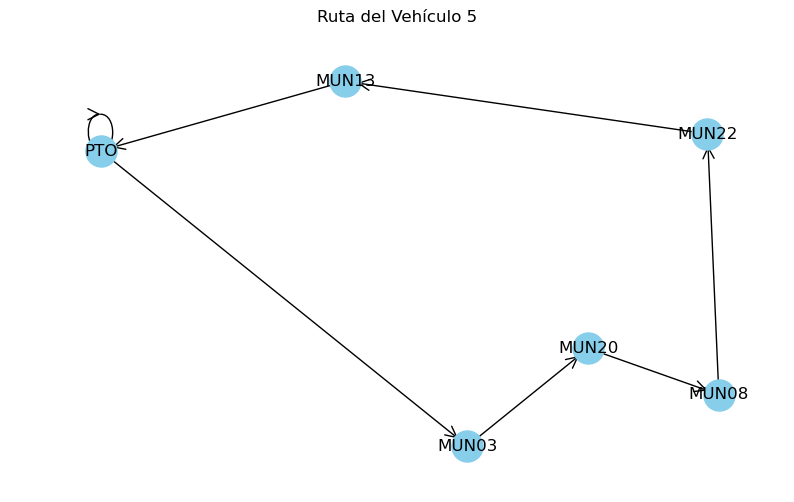

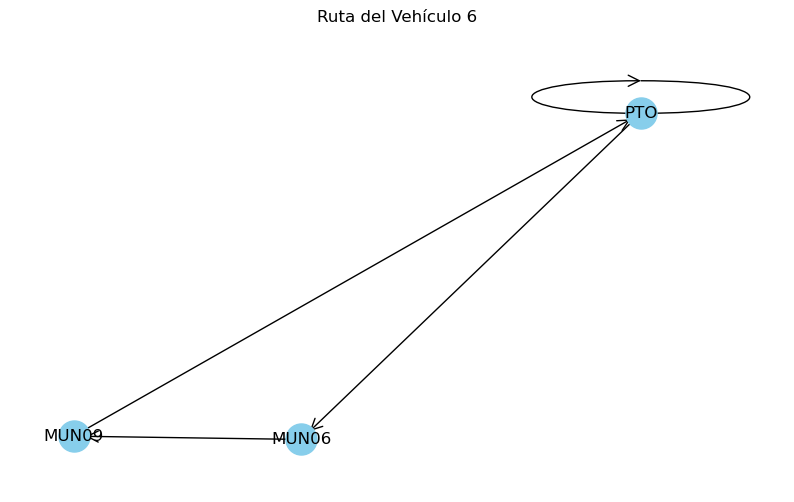

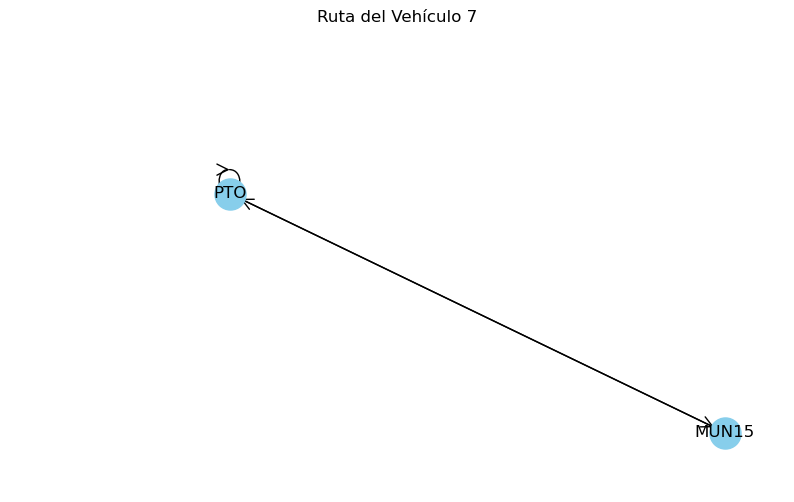

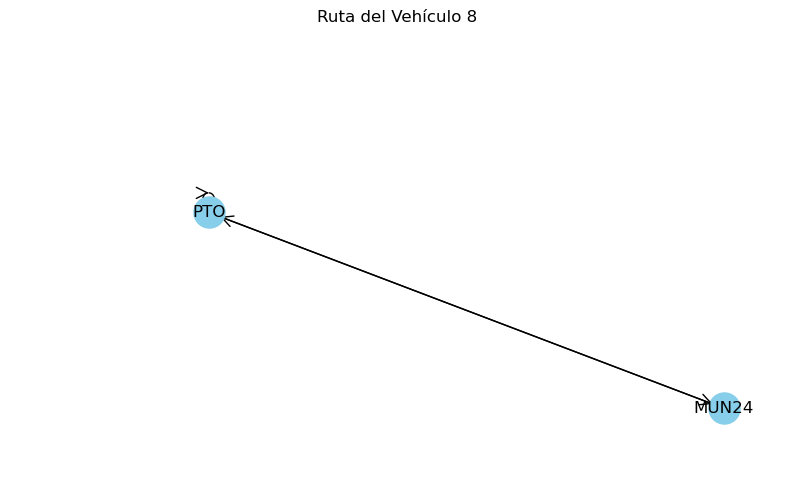

In [7]:
# Coordenadas de cada nodo
coords = {i+1: (locations_csv['Longitude'][i], locations_csv['Latitude'][i]) for i in range(len(locations_csv))}

for k in V:
    G = nx.DiGraph()
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break

    if len(ruta) > 1:
        ruta.append(1)  # cerrar ciclo

        G.add_nodes_from(ruta)
        for i in range(len(ruta)-1):
            G.add_edge(ruta[i], ruta[i+1])

        plt.figure(figsize=(10,6))
        pos = {n: coords[n] for n in ruta}
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
        nx.draw_networkx_labels(G, pos, labels={n: f"{'PTO' if n==1 else f'MUN{n:02d}'}" for n in ruta})
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
        plt.title(f"Ruta del Vehículo {k}")
        plt.axis('off')
        plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_8324\5199535.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(V))  # Usa una paleta de 10 colores


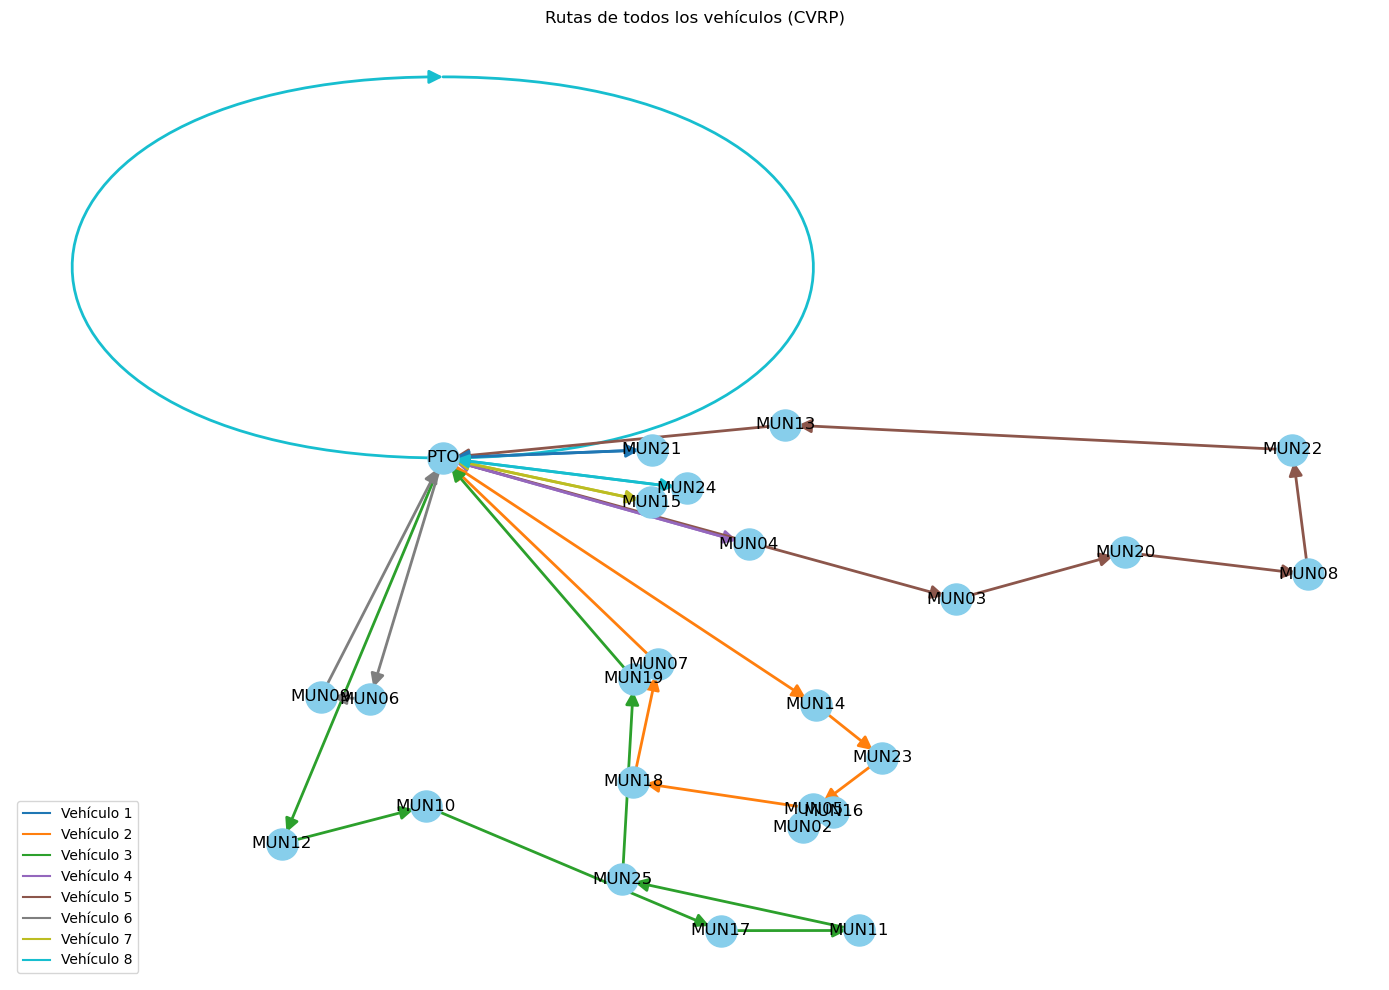

In [8]:
# Crear coordenadas a partir del CSV
coords = {i+1: (locations_csv['Longitude'][i], locations_csv['Latitude'][i]) for i in range(len(locations_csv))}

# Crear grafo general
G = nx.DiGraph()

# Agregar todos los nodos
G.add_nodes_from(coords.keys())

# Colores únicos para cada vehículo
color_map = cm.get_cmap('tab10', len(V))  # Usa una paleta de 10 colores

# Construir rutas por vehículo y agregarlas al grafo
for idx, k in enumerate(V):
    color = mcolors.to_hex(color_map(idx))
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break

    if len(ruta) > 1:
        ruta.append(1)  # cerrar ciclo
        for i in range(len(ruta)-1):
            G.add_edge(ruta[i], ruta[i+1], color=color, vehicle=k)

# Obtener posiciones de los nodos (longitud, latitud)
pos = {n: coords[n] for n in G.nodes}

# Dibujar nodos
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels={n: f"{'PTO' if n==1 else f'MUN{n:02d}'}" for n in G.nodes})

# Dibujar aristas coloreadas por vehículo
edges = G.edges(data=True)
for edge in edges:
    i, j, attr = edge
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(i, j)],
        edge_color=attr['color'],
        width=2,
        arrows=True,
        arrowsize=20
    )

# Agregar leyenda de vehículos
for idx, k in enumerate(V):
    plt.plot([], [], color=mcolors.to_hex(color_map(idx)), label=f'Vehículo {k}')
plt.legend(loc='lower left')

plt.title("Rutas de todos los vehículos (CVRP)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
# Cargar coordenadas
coordenadas = locations_csv[['Latitude', 'Longitude']].values.tolist()

# Crear mapa centrado en el depósito
lat_centro = coordenadas[0][0]
lon_centro = coordenadas[0][1]
mapa = folium.Map(location=[lat_centro, lon_centro], zoom_start=8)

# Colores para diferenciar vehículos
colores = [
    'blue', 'orange', 'green', 'purple', 'brown', 'olive', 'gray', 'cyan'
]

# Costos
velocidad = 50
tarifa_flete = 5000
costo_mantenimiento = 700
costo_km = tarifa_flete + costo_mantenimiento  # 5700

# Añadir puntos al mapa
for i, coord in enumerate(coordenadas):
    nombre = "PTO" if i == 0 else f"MUN{str(i).zfill(2)}"
    folium.CircleMarker(location=coord, radius=4, color="black", fill=True, popup=nombre).add_to(mapa)

# Añadir rutas
for k in V:
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1:
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break
    if len(ruta) <= 1:
        continue  # vehículo no utilizado

    # Coordenadas y etiquetas
    puntos = [coordenadas[i-1] for i in ruta]
    distancia = sum(distancias[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))
    costo = round(distancia * costo_km)

    folium.PolyLine(
        puntos,
        color=colores[k-1],
        weight=4,
        opacity=0.8,
        tooltip=f'🚚 Vehículo {k} - Distancia: {round(distancia,1)} km - Costo: ${costo}'
    ).add_to(mapa)

# Guardar
mapa.save('Proyecto_Caso_Base/ruta_vehiculos_interactiva.html')
print("✅ Mapa interactivo guardado como 'ruta_vehiculos_interactiva.html'")

✅ Mapa interactivo guardado como 'ruta_vehiculos_interactiva.html'


# Análisis general
El Caso 1 corresponde a la versión más sencilla del problema logístico planteado, y actúa como línea base para comparar el impacto de restricciones adicionales en etapas posteriores. En esta instancia, se modela un problema clásico de ruteo de vehículos con capacidad (CVRP), donde el objetivo es determinar las rutas óptimas para una flota de camiones que parte y retorna a un único punto de origen (el puerto), atendiendo la demanda de un conjunto de municipios distribuidos a nivel nacional.

La formulación del modelo considera restricciones esenciales: cada cliente debe ser atendido exactamente una vez, los vehículos no deben exceder su capacidad de carga ni su autonomía máxima, y las rutas deben evitar ciclos intermedios. Esta estructura permite validar que los datos y parámetros del problema son consistentes y que es posible cubrir la totalidad de la demanda sin necesidad de estaciones de recarga u otros elementos logísticos complejos.

El propósito principal de este caso es comprobar la factibilidad operativa bajo condiciones ideales y establecer un punto de referencia para evaluar mejoras o impactos en el rendimiento logístico cuando se incorporan decisiones adicionales como recarga de combustible, tarifas de peaje o restricciones municipales en los casos 2 y 3. A pesar de su simplicidad, el modelo del Caso 1 ya permite observar la relación directa entre distancia, carga y costo total, lo cual proporciona información valiosa para la toma de decisiones iniciales en escenarios de planificación logística nacional.

## Cómo visualizar el mapa interactivo de rutas con Folium

Este procedimiento permite generar y visualizar un mapa interactivo con las rutas de vehículos calculadas por el modelo CVRP, usando la librería `folium`. En el mapa resultado se puede ver el recorrido de cada vehículo con su costo respectivo. A continuacion hay una breve instrucción para poder ver dicho mapa.

![MapaInteractivo](Proyecto_Caso_Base/i_mapaInteractivoCasoBasico.png)

---

### Ubica el archivo generado

En tu explorador de archivos, navega a:

`Proyecto_Caso_Base/ruta_vehiculos_interactiva.html`

Haz clic derecho en el archivo `ruta_vehiculos_interactiva.html`. Acá selecciona Abrir en Browser o Show in Browser, para que selecciones tu navegador preferido y puedas navegar en el mapa

 ![kkk](Proyecto_Caso_Base/i_comoVerMapa.png) 

---

# Análisis Final del Caso Base – Problema CVRP

---

## Objetivo General

El objetivo fue diseñar rutas óptimas para un conjunto de vehículos que deben cubrir la demanda de múltiples municipios, partiendo y regresando a un único depósito. Las rutas debían minimizar la distancia total recorrida, sin superar la capacidad ni la autonomía de cada vehículo.

---

## Resultados Obtenidos

- Se encontró una solución factible al problema, cumpliendo todas las restricciones operativas:
  - Cada cliente fue visitado exactamente una vez.
  - Ningún vehículo superó su capacidad de carga.
  - Ninguna ruta excedió la autonomía máxima permitida.
- El costo total estimado en función de la distancia y tarifas logísticas fue calculado y desglosado por vehículo.
- Las rutas obtenidas fueron visualizadas en un mapa interactivo, facilitando la validación gráfica del modelo.

---

### Conclusión

La implementación del modelo base para el Caso 1 permitió validar la factibilidad de una estrategia logística nacional considerando únicamente restricciones fundamentales: demanda, capacidad de los vehículos y autonomía. El modelo, formulado como un problema de ruteo de vehículos (CVRP) y resuelto mediante Pyomo y el solver GLPK, demostró ser suficiente para garantizar la cobertura completa de todos los destinos a partir de un único centro de distribución (el puerto).

Gracias al uso de la formulación MTZ para la eliminación de subciclos, se obtuvo un conjunto de rutas sin redundancias, en las que cada cliente es atendido una única vez. La estructura centralizada de rutas con retorno al puerto generó soluciones eficientes y fácilmente interpretables desde el punto de vista operativo.

En términos de uso de recursos, el modelo logró una asignación adecuada de la carga entre los diferentes vehículos, maximizando la utilización de su capacidad sin exceder los límites de autonomía. El análisis de resultados evidencia un comportamiento balanceado en los costos totales por vehículo, asociado directamente a la cantidad de municipios atendidos y la distancia cubierta por cada ruta.

Aunque el modelo no contempla decisiones adicionales como recargas o peajes, el Caso 1 sirve como línea base para comparar la evolución de la complejidad y la eficiencia en los siguientes escenarios. Su simplicidad estructural permitió evaluar el rendimiento del sistema bajo condiciones ideales, lo cual es clave para interpretar de manera aislada el impacto de nuevas restricciones introducidas en los casos posteriores.

